# Notebook 8: Transformer Model

## Objective
- Train a transformer model on the prepared sequences to predict asset price movements.

## Reasons for Using Transformer Model
This notebook trains a Transformer-based neural network to predict whether Apple (AAPL) stock will move up or down one day ahead. Unlike recurrent architectures like LSTM or GRU, transformers use self-attention mechanisms to capture relationships between different time steps without processing data sequentially. This allows them to identify long-range dependencies more efficiently.

The transformer architecture has proven successful in natural language processing and is increasingly applied to time series forecasting. We test whether its attention mechanism can identify meaningful patterns in financial market data.

## Approach

We focus exclusively on AAPL with a 1-day prediction horizon. This focused approach allows us to thoroughly explore hyperparameter space and understand model behavior before scaling to other assets. We conduct an exhaustive grid search across key architectural parameters to identify the optimal configuration.

After training, we evaluate model performance on other assets like amazon (AMZN), s&p 500 (GSPC), and bitcoin (BTC-USD) to assess generalization capabilities.

___
## Table of Contents

1. [Configuration and Setup](#1-configuration-and-setup)
2. [Load Data and Examine Structure](#2-load-data-and-examine-structure)
3. [Build and Visualize Transformer Architecture](#3-build-and-visualize-transformer-architecture)
4. [Baseline Model Training on AAPL for 1-day](#4-baseline-model-training)
5. [Grid Search for Hyperparameter Tuning](#5-hyperparameter-grid-search)
6. [Final Evaluation on Test Set](#6-final-evaluation-on-test-set)
7. [Evaluation on Different Horizons](#7-evaluation-on-different-horizons)
8. [Evaluation on Other Assets](#8-evaluation-on-other-assets)

---

# 1. Configuration and Setup

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pickle
import os
import sys
from datetime import datetime
from itertools import product

# Add utils directory to path
sys.path.append('../utils')
from utils import (
    build_transformer_model, 
    load_sequences, 
    load_class_weights,
    get_callbacks,
    plot_training_history
)

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define directories
SEQUENCES_DIR = '../data_new/sequences/'
MODELS_DIR = '../models/transformer/'
RESULTS_DIR = '../results/'
FIGURES_DIR = '../figures/'

# Assets and horizons for evaluation
ASSETS = ['AAPL', 'AMZN', 'NVDA', 'SPY', 'BTC-USD']
HORIZONS = ['1day', '1week', '1month']

# Create output directories if they don't exist
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# Configure visualization style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
print("\n[OK] Setup complete - all libraries loaded successfully")

TensorFlow version: 2.20.0
GPU available: []

[OK] Setup complete - all libraries loaded successfully


# 2. Load Data and Examine Structure

We begin by loading the preprocessed sequences for AAPL with a 1-day prediction horizon. These sequences were created in the data preprocessing notebook and contain technical indicators, price features, and volume information organized into fixed-length windows.

In [59]:
# Load AAPL 1-day sequences
asset = 'AAPL'
horizon = '1day'

print(f"Loading data for {asset} with {horizon} prediction horizon...")
X_train, X_val, X_test, y_train, y_val, y_test, seq_len, n_feat = load_sequences(asset, horizon)

print(f"\n{'='*80}")
print("DATA STRUCTURE")
print('='*80)
print(f"Training set:   {X_train.shape} -> {y_train.shape}")
print(f"Validation set: {X_val.shape} -> {y_val.shape}")
print(f"Test set:       {X_test.shape} -> {y_test.shape}")
print(f"\nSequence length: {seq_len} days")
print(f"Number of features: {n_feat}")

# Load class weights to handle imbalanced data
class_weights = load_class_weights()
cw = class_weights[asset][horizon]
class_weight_dict = {0: cw[0], 1: cw[1]}

print(f"\n{'='*80}")
print("CLASS DISTRIBUTION")
print('='*80)
print(f"Training set - DOWN: {(y_train==0).sum()} ({(y_train==0).mean()*100:.1f}%)")
print(f"Training set - UP:   {(y_train==1).sum()} ({(y_train==1).mean()*100:.1f}%)")
print(f"\nClass weights applied: DOWN={cw[0]:.3f}, UP={cw[1]:.3f}")
print("These weights compensate for class imbalance during training.")

print("\n[OK] Data loaded successfully")

Loading data for AAPL with 1day prediction horizon...

DATA STRUCTURE
Training set:   (4405, 7, 39) -> (4405,)
Validation set: (623, 7, 39) -> (623,)
Test set:       (1254, 7, 39) -> (1254,)

Sequence length: 7 days
Number of features: 39

CLASS DISTRIBUTION
Training set - DOWN: 2121 (48.1%)
Training set - UP:   2284 (51.9%)

Class weights applied: DOWN=1.038, UP=0.964
These weights compensate for class imbalance during training.

[OK] Data loaded successfully


# 3. Build and Visualize Transformer Architecture

The transformer model consists of several key components:

1. **Multi-head self-attention**: Allows the model to attend to different parts of the input sequence simultaneously. Each "head" learns different patterns.

2. **Feed-forward networks**: Process the attention outputs through dense layers with ReLU activation.

3. **Layer normalization and residual connections**: Stabilize training and allow gradients to flow effectively through deep networks.

4. **Global average pooling**: Aggregates information across all time steps before the final classification layer.

In [60]:
# Build a sample transformer model for visualization
sample_model = utils.build_transformer_model(
    sequence_length=seq_len,
    n_features=n_feat,
    num_transformer_blocks=2,
    head_size=128,
    num_heads=4,
    ff_dim=128,
    dropout_rate=0.2,
    dense_units=64,
    learning_rate=0.001
)

print("TRANSFORMER ARCHITECTURE")
print("="*80)
sample_model.summary()

print(f"\nTotal parameters: {sample_model.count_params():,}")
print(f"\nKey architectural choices:")
print(f"  - {2} transformer encoder blocks stacked sequentially")
print(f"  - {4} attention heads per block (each head size: {128})")
print(f"  - Feed-forward dimension: {128}")
print(f"  - Dropout rate: {0.2} (applied after each layer)")
print(f"  - Final dense layer: {64} units before binary classification")

print("\n[OK] Model architecture defined")

TRANSFORMER ARCHITECTURE


Model: "Transformer_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_77      │ (None, 7, 39)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 39)     │     81,447 │ input_layer_77[0… │
│ (MultiHeadAttentio… │                   │            │ input_layer_77[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_566         │ (None, 7, 39)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_244 (Add)       │ (None, 7, 39)     │          0 │ input_layer_77[0… │
│                     │                   │            │ dropout_566[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 39)     │         78 │ add_244[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_398 (Dense)   │ (None, 7, 128)    │      5,120 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_567         │ (None, 7, 128)    │          0 │ dense_398[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_399 (Dense)   │ (None, 7, 39)     │      5,031 │ dropout_567[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_568         │ (None, 7, 39)     │          0 │ dense_399[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_245 (Add)       │ (None, 7, 39)     │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_568[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 39)     │         78 │ add_245[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 39)     │     81,447 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_570         │ (None, 7, 39)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_246 (Add)       │ (None, 7, 39)     │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_570[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 39)     │         78 │ add_246[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_400 (Dense)   │ (None, 7, 128)    │      5,120 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_571         │ (None, 7, 128)    │          0 │ dense_400[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_401 (Dense)   │ (None, 7, 39)     │      5,031 │ dropout_571[0][0

 Total params: 186,133 (727.08 KB)

 Trainable params: 186,133 (727.08 KB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 186,133

Key architectural choices:
  - 2 transformer encoder blocks stacked sequentially
  - 4 attention heads per block (each head size: 128)
  - Feed-forward dimension: 128
  - Dropout rate: 0.2 (applied after each layer)
  - Final dense layer: 64 units before binary classification

[OK] Model architecture defined


# 4. Baseline Model Training on AAPL for 1-day

Before conducting a full grid search, we train a baseline model with the default parameters shown above. This gives us a reference point to understand whether hyperparameter tuning provides meaningful improvements.

The model is trained with early stopping, meaning training will halt if validation loss stops improving for 10 consecutive epochs. This prevents overfitting and saves computational resources.

In [61]:
print("Training baseline transformer model...")
print("="*80)

# Train the baseline model
history_baseline = sample_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=get_callbacks(f'Transformer_{asset}_{horizon}_baseline', MODELS_DIR=MODELS_DIR),
    verbose=1
)

print("\n[OK] Baseline training complete")
print(f"Training stopped at epoch {len(history_baseline.history['loss'])}")

Training baseline transformer model...
Epoch 1/100
137/138 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5053 - auc: 0.5077 - loss: 0.7106 - precision: 0.5247 - recall: 0.5268

138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5110 - auc: 0.5132 - loss: 0.7043 - precision: 0.5288 - recall: 0.5228 - val_accuracy: 0.5249 - val_auc: 0.4793 - val_loss: 0.6918 - val_precision: 0.5416 - val_recall: 0.8921 - learning_rate: 0.0010
Epoch 2/100
137/138 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5177 - auc: 0.5012 - loss: 0.6952 - precision: 0.5304 - recall: 0.5937

138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5094 - auc: 0.5104 - loss: 0.6953 - precision: 0.5292 - recall: 0.4886 - val_accuracy: 0.5506 - val_auc: 0.5167 - val_loss: 0.6883 - val_precision: 0.5506 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5117 - auc: 0.5202 - loss: 0.6936 - precision: 0.5307 - recall: 0.5026 - val_accuracy: 0.5072 - val_auc: 0.4580 - val_loss: 0.6952 - val_precision: 0.5388 - val_recall: 0.7289 - learning_rate: 0.0010
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5185 - auc: 0.5245 - loss: 0.6929 - precision: 0.5369 - recall: 0.5188 - val_accuracy: 0.5040 - val_auc: 0.5104 - val_loss: 0.6934 - val_precision: 0.5494 - val_recall: 0.5510 - learning_rate: 0.0010
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5087 - auc: 0.5229 - loss: 0.6930 - precision: 0.5377 - recall: 0.3743 - val_accuracy: 0.4446 - val_auc: 0.4668 - val_loss: 0.7072 - val_pre

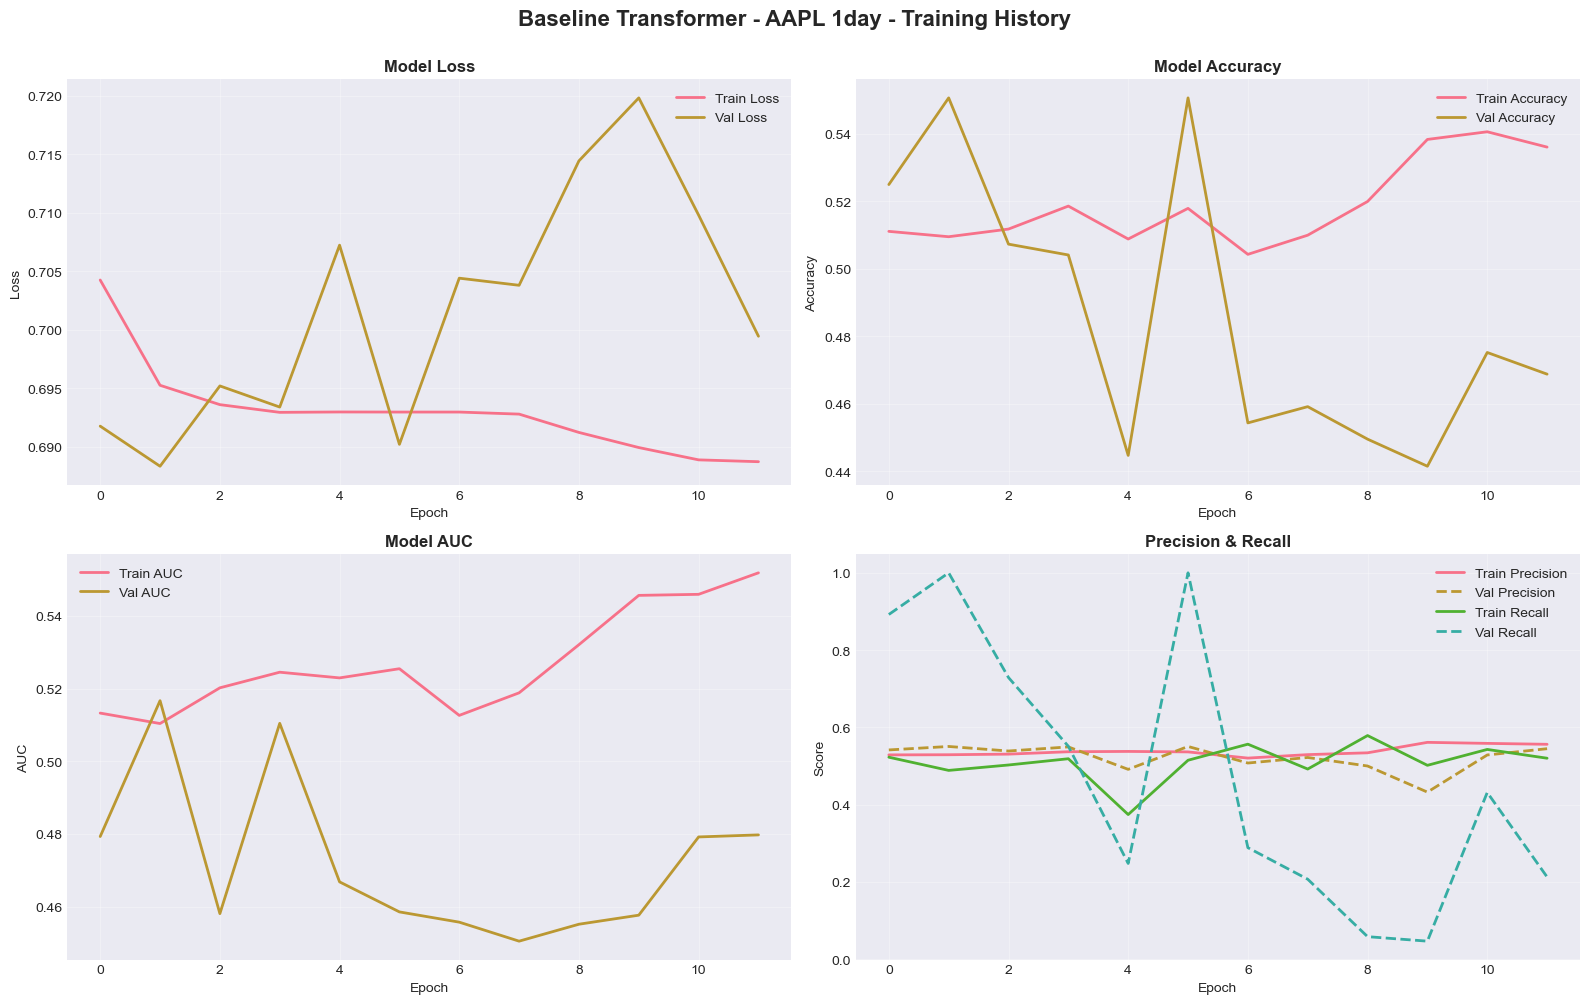

[OK] Training history displayed


In [62]:
# Visualize training history
utils.plot_training_history(
    history_baseline, 
    f"Baseline Transformer - {asset} {horizon}",
    save_path=None
)

print("[OK] Training history displayed")

In [63]:
# Generate predictions on test set
y_pred_proba_baseline = sample_model.predict(X_test, verbose=0)
y_pred_baseline = (y_pred_proba_baseline > 0.5).astype(int).flatten()

# Calculate metrics
baseline_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_baseline),
    'precision': precision_score(y_test, y_pred_baseline),
    'recall': recall_score(y_test, y_pred_baseline),
    'f1': f1_score(y_test, y_pred_baseline),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_baseline)
}

print("\n" + "="*80)
print("BASELINE MODEL PERFORMANCE (Test Set)")
print("="*80)
for metric, value in baseline_metrics.items():
    print(f"{metric.capitalize():12s}: {value:.4f}")

print(f"\nInterpretation:")
print(f"  - Accuracy above 0.50 indicates the model has learned useful patterns")
print(f"  - ROC-AUC measures the model's ability to rank predictions correctly")
print(f"  - F1 score balances precision and recall for imbalanced classes")

print("\n[OK] Baseline evaluation complete")


BASELINE MODEL PERFORMANCE (Test Set)
Accuracy    : 0.5311
Precision   : 0.5311
Recall      : 1.0000
F1          : 0.6937
Roc_auc     : 0.5139

Interpretation:
  - Accuracy above 0.50 indicates the model has learned useful patterns
  - ROC-AUC measures the model's ability to rank predictions correctly
  - F1 score balances precision and recall for imbalanced classes

[OK] Baseline evaluation complete


# 5. Grid Search for Hyperparameter Tuning

To find the optimal transformer configuration, we conduct an exhaustive grid search across key hyperparameters. Each combination is trained and evaluated on the validation set. This systematic approach ensures we identify the best-performing architecture.

## Hyperparameter Space

We test the following parameters:

- **Number of transformer blocks** (1 or 2): More blocks allow deeper representations but increase computational cost
- **Number of attention heads** (2 or 4): Multiple heads let the model attend to different patterns simultaneously  
- **Head size** (64 or 128): Larger heads have more capacity but risk overfitting
- **Feed-forward dimension** (128 or 256): Controls the width of the dense layers within each transformer block
- **Dropout rate** (0.2 or 0.3): Higher dropout provides stronger regularization
- **Learning rate** (0.0005 or 0.001): Lower rates train slower but may find better optima

This creates 2^6 = 64 total configurations. Each takes approximately 2-3 minutes to train, so the full grid search should complete in roughly 2-3 hours.

In [46]:
# Define hyperparameter grid
param_grid = {
    'num_transformer_blocks': [1, 2],
    'num_heads': [2, 4],
    'head_size': [64, 128],
    'ff_dim': [128, 256],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.0005, 0.001]
}

# Generate all combinations using itertools.product
keys = param_grid.keys()
values = param_grid.values()
combinations = [dict(zip(keys, v)) for v in product(*values)]

print(f"HYPERPARAMETER GRID SEARCH")
print("="*80)
print(f"Total combinations: {len(combinations)}")
print(f"\nParameter ranges:")
for param, vals in param_grid.items():
    print(f"  {param:25s}: {vals}")

print(f"\nEstimated time: ~{len(combinations) * 2:.0f}-{len(combinations) * 3:.0f} minutes")
print("="*80)

HYPERPARAMETER GRID SEARCH
Total combinations: 64

Parameter ranges:
  num_transformer_blocks   : [1, 2]
  num_heads                : [2, 4]
  head_size                : [64, 128]
  ff_dim                   : [128, 256]
  dropout_rate             : [0.2, 0.3]
  learning_rate            : [0.0005, 0.001]

Estimated time: ~128-192 minutes


In [47]:
# Execute grid search
grid_results = []
start_time = datetime.now()

print("\nStarting grid search...")
print("="*80)

for idx, params in enumerate(combinations, 1):
    print(f"\n[{idx}/{len(combinations)}] Testing configuration...")
    for k, v in params.items():
        print(f"  {k:25s}: {v}")
    
    # Build model with current parameters
    model = build_transformer_model(
        sequence_length=seq_len,
        n_features=n_feat,
        num_transformer_blocks=params['num_transformer_blocks'],
        head_size=params['head_size'],
        num_heads=params['num_heads'],
        ff_dim=params['ff_dim'],
        dropout_rate=params['dropout_rate'],
        dense_units=64,  # Keep fixed
        learning_rate=params['learning_rate']
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks=get_callbacks(f'Transformer_grid_{idx}', MODELS_DIR=MODELS_DIR),
        verbose=0
    )
    
    # Evaluate on validation set
    y_val_pred_proba = model.predict(X_val, verbose=0)
    y_val_pred = (y_val_pred_proba > 0.5).astype(int).flatten()
    
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_auc = roc_auc_score(y_val, y_val_pred_proba)
    val_f1 = f1_score(y_val, y_val_pred)
    
    # Store results
    result = {
        **params,
        'val_accuracy': val_accuracy,
        'val_auc': val_auc,
        'val_f1': val_f1,
        'epochs_trained': len(history.history['loss']),
        'final_val_loss': history.history['val_loss'][-1],
        'parameters': model.count_params()
    }
    grid_results.append(result)
    
    print(f"  → Val Accuracy: {val_accuracy:.4f} | Val AUC: {val_auc:.4f} | Val F1: {val_f1:.4f}")
    print(f"  → Epochs: {result['epochs_trained']} | Params: {result['parameters']:,}")

elapsed = (datetime.now() - start_time).total_seconds()
print(f"\n{'='*80}")
print(f"[OK] Grid search complete in {elapsed/60:.1f} minutes")
print("="*80)


Starting grid search...

[1/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 128
  dropout_rate             : 0.2
  learning_rate            : 0.0005



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.4928 | Val AUC: 0.4770 | Val F1: 0.5269
  → Epochs: 11 | Params: 33,323

[2/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 128
  dropout_rate             : 0.2
  learning_rate            : 0.001
  → Val Accuracy: 0.4928 | Val AUC: 0.4770 | Val F1: 0.5269
  → Epochs: 11 | Params: 33,323

[2/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 128
  dropout_rate             


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.4543 | Val AUC: 0.4670 | Val F1: 0.4801
  → Epochs: 11 | Params: 33,323

[3/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 128
  dropout_rate             : 0.3
  learning_rate            : 0.0005
  → Val Accuracy: 0.4543 | Val AUC: 0.4670 | Val F1: 0.4801
  → Epochs: 11 | Params: 33,323

[3/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 128
  dropout_rate            


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.
  → Val Accuracy: 0.5120 | Val AUC: 0.5159 | Val F1: 0.5408
  → Epochs: 13 | Params: 33,323

[4/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 128
  dropout_rate             : 0.3
  learning_rate            : 0.001
  → Val Accuracy: 0.5120 | Val AUC: 0.5159 | Val F1: 0.5408
  → Epochs: 13 | Params: 33,323

[4/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 128
  dropout_rate             


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.
  → Val Accuracy: 0.4639 | Val AUC: 0.4926 | Val F1: 0.2409
  → Epochs: 20 | Params: 33,323

[5/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 256
  dropout_rate             : 0.2
  learning_rate            : 0.0005
  → Val Accuracy: 0.4639 | Val AUC: 0.4926 | Val F1: 0.2409
  → Epochs: 20 | Params: 33,323

[5/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 256
  dropout_rate         


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 4.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 4.
  → Val Accuracy: 0.4767 | Val AUC: 0.4989 | Val F1: 0.3707
  → Epochs: 14 | Params: 43,435

[6/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 256
  dropout_rate             : 0.2
  learning_rate            : 0.001
  → Val Accuracy: 0.4767 | Val AUC: 0.4989 | Val F1: 0.3707
  → Epochs: 14 | Params: 43,435

[6/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 256
  dropout_rate             


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.4976 | Val AUC: 0.4850 | Val F1: 0.4401
  → Epochs: 11 | Params: 43,435

[7/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 256
  dropout_rate             : 0.3
  learning_rate            : 0.0005
  → Val Accuracy: 0.4976 | Val AUC: 0.4850 | Val F1: 0.4401
  → Epochs: 11 | Params: 43,435

[7/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 256
  dropout_rate            


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.4799 | Val AUC: 0.4830 | Val F1: 0.5061
  → Epochs: 11 | Params: 43,435

[8/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 256
  dropout_rate             : 0.3
  learning_rate            : 0.001
  → Val Accuracy: 0.4799 | Val AUC: 0.4830 | Val F1: 0.5061
  → Epochs: 11 | Params: 43,435

[8/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 256
  dropout_rate             


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12: early stopping

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
Restoring model weights from the end of the best epoch: 2.
  → Val Accuracy: 0.5104 | Val AUC: 0.4866 | Val F1: 0.5722
  → Epochs: 12 | Params: 43,435

[9/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 128
  dropout_rate             : 0.2
  learning_rate            : 0.0005
  → Val Accuracy: 0.5104 | Val AUC: 0.4866 | Val F1: 0.5722
  → Epochs: 12 | Params: 43,435

[9/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 128
  dropout_rate          


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.4478 | Val AUC: 0.4571 | Val F1: 0.3944
  → Epochs: 11 | Params: 53,675

[10/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 128
  dropout_rate             : 0.2
  learning_rate            : 0.001
  → Val Accuracy: 0.4478 | Val AUC: 0.4571 | Val F1: 0.3944
  → Epochs: 11 | Params: 53,675

[10/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 128
  dropout_rate             : 0.2
  learning_rate            : 0.001



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 16: early stopping

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.
Restoring model weights from the end of the best epoch: 6.
  → Val Accuracy: 0.5120 | Val AUC: 0.5002 | Val F1: 0.5463
  → Epochs: 16 | Params: 53,675

[11/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 128
  dropout_rate             : 0.3
  learning_rate            : 0.0005
  → Val Accuracy: 0.5120 | Val AUC: 0.5002 | Val F1: 0.5463
  → Epochs: 16 | Params: 53,675

[11/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 128
  dropout_rate       


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
  → Val Accuracy: 0.5361 | Val AUC: 0.5052 | Val F1: 0.6328
  → Epochs: 12 | Params: 53,675

[12/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 128
  dropout_rate             : 0.3
  learning_rate            : 0.001
  → Val Accuracy: 0.5361 | Val AUC: 0.5052 | Val F1: 0.6328
  → Epochs: 12 | Params: 53,675

[12/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 128
  dropout_rate         


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.
  → Val Accuracy: 0.5185 | Val AUC: 0.5205 | Val F1: 0.5575
  → Epochs: 16 | Params: 53,675

[13/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 256
  dropout_rate             : 0.2
  learning_rate            : 0.0005
  → Val Accuracy: 0.5185 | Val AUC: 0.5205 | Val F1: 0.5575
  → Epochs: 16 | Params: 53,675

[13/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 256
  dropout_rate       


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 14: early stopping

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 4.
Restoring model weights from the end of the best epoch: 4.
  → Val Accuracy: 0.4655 | Val AUC: 0.4612 | Val F1: 0.2960
  → Epochs: 14 | Params: 63,787

[14/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 256
  dropout_rate             : 0.2
  learning_rate            : 0.001
  → Val Accuracy: 0.4655 | Val AUC: 0.4612 | Val F1: 0.2960
  → Epochs: 14 | Params: 63,787

[14/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 256
  dropout_rate         


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.4751 | Val AUC: 0.4631 | Val F1: 0.4666
  → Epochs: 11 | Params: 63,787

[15/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 256
  dropout_rate             : 0.3
  learning_rate            : 0.0005
  → Val Accuracy: 0.4751 | Val AUC: 0.4631 | Val F1: 0.4666
  → Epochs: 11 | Params: 63,787

[15/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 256
  dropout_rate        


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.4944 | Val AUC: 0.5113 | Val F1: 0.4241
  → Epochs: 11 | Params: 63,787

[16/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 256
  dropout_rate             : 0.3
  learning_rate            : 0.001
  → Val Accuracy: 0.4944 | Val AUC: 0.5113 | Val F1: 0.4241
  → Epochs: 11 | Params: 63,787

[16/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 256
  dropout_rate         


Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 5.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 5.
  → Val Accuracy: 0.4960 | Val AUC: 0.4726 | Val F1: 0.5449
  → Epochs: 15 | Params: 63,787

[17/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 128
  dropout_rate             : 0.2
  learning_rate            : 0.0005
  → Val Accuracy: 0.4960 | Val AUC: 0.4726 | Val F1: 0.5449
  → Epochs: 15 | Params: 63,787

[17/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 128
  dropout_rate         


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.4639 | Val AUC: 0.4739 | Val F1: 0.2924
  → Epochs: 11 | Params: 53,675

[18/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 128
  dropout_rate             : 0.2
  learning_rate            : 0.001
  → Val Accuracy: 0.4639 | Val AUC: 0.4739 | Val F1: 0.2924
  → Epochs: 11 | Params: 53,675

[18/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 128
  dropout_rate           


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.5490 | Val AUC: 0.5270 | Val F1: 0.6014
  → Epochs: 11 | Params: 53,675

[19/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 128
  dropout_rate             : 0.3
  learning_rate            : 0.0005
  → Val Accuracy: 0.5490 | Val AUC: 0.5270 | Val F1: 0.6014
  → Epochs: 11 | Params: 53,675

[19/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 128
  dropout_rate          


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.5136 | Val AUC: 0.5159 | Val F1: 0.5511
  → Epochs: 11 | Params: 53,675

[20/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 128
  dropout_rate             : 0.3
  learning_rate            : 0.001
  → Val Accuracy: 0.5136 | Val AUC: 0.5159 | Val F1: 0.5511
  → Epochs: 11 | Params: 53,675

[20/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 128
  dropout_rate           


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.
  → Val Accuracy: 0.5104 | Val AUC: 0.5016 | Val F1: 0.5455
  → Epochs: 13 | Params: 53,675

[21/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 256
  dropout_rate             : 0.2
  learning_rate            : 0.0005
  → Val Accuracy: 0.5104 | Val AUC: 0.5016 | Val F1: 0.5455
  → Epochs: 13 | Params: 53,675

[21/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 256
  dropout_rate          


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
  → Val Accuracy: 0.4703 | Val AUC: 0.4884 | Val F1: 0.4554
  → Epochs: 12 | Params: 63,787

[22/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 256
  dropout_rate             : 0.2
  learning_rate            : 0.001
  → Val Accuracy: 0.4703 | Val AUC: 0.4884 | Val F1: 0.4554
  → Epochs: 12 | Params: 63,787

[22/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 256
  dropout_rate           


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.4912 | Val AUC: 0.4724 | Val F1: 0.5529
  → Epochs: 11 | Params: 63,787

[23/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 256
  dropout_rate             : 0.3
  learning_rate            : 0.0005
  → Val Accuracy: 0.4912 | Val AUC: 0.4724 | Val F1: 0.5529
  → Epochs: 11 | Params: 63,787

[23/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 256
  dropout_rate          


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.5136 | Val AUC: 0.5162 | Val F1: 0.4694
  → Epochs: 11 | Params: 63,787

[24/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 256
  dropout_rate             : 0.3
  learning_rate            : 0.001
  → Val Accuracy: 0.5136 | Val AUC: 0.5162 | Val F1: 0.4694
  → Epochs: 11 | Params: 63,787

[24/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 256
  dropout_rate           


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
  → Val Accuracy: 0.5185 | Val AUC: 0.4669 | Val F1: 0.6622
  → Epochs: 12 | Params: 63,787

[25/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 128
  dropout_rate             : 0.2
  learning_rate            : 0.0005
  → Val Accuracy: 0.5185 | Val AUC: 0.4669 | Val F1: 0.6622
  → Epochs: 12 | Params: 63,787

[25/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 128
  dropout_rate        


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.
  → Val Accuracy: 0.4703 | Val AUC: 0.4724 | Val F1: 0.4349
  → Epochs: 16 | Params: 94,379

[26/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 128
  dropout_rate             : 0.2
  learning_rate            : 0.001
  → Val Accuracy: 0.4703 | Val AUC: 0.4724 | Val F1: 0.4349
  → Epochs: 16 | Params: 94,379

[26/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 128
  dropout_rate        


Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 5.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 5.
  → Val Accuracy: 0.4960 | Val AUC: 0.5103 | Val F1: 0.4207
  → Epochs: 15 | Params: 94,379

[27/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 128
  dropout_rate             : 0.3
  learning_rate            : 0.0005
  → Val Accuracy: 0.4960 | Val AUC: 0.5103 | Val F1: 0.4207
  → Epochs: 15 | Params: 94,379

[27/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 128
  dropout_rate       


Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.4992 | Val AUC: 0.5225 | Val F1: 0.4602
  → Epochs: 11 | Params: 94,379

[28/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 128
  dropout_rate             : 0.3
  learning_rate            : 0.001
  → Val Accuracy: 0.4992 | Val AUC: 0.5225 | Val F1: 0.4602
  → Epochs: 11 | Params: 94,379

[28/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 128
  dropout_rate             : 0.3
  learning_rate            : 0.001



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.4831 | Val AUC: 0.4813 | Val F1: 0.4124
  → Epochs: 11 | Params: 94,379

[29/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 256
  dropout_rate             : 0.2
  learning_rate            : 0.0005
  → Val Accuracy: 0.4831 | Val AUC: 0.4813 | Val F1: 0.4124
  → Epochs: 11 | Params: 94,379

[29/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 256
  dropout_rate        


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
  → Val Accuracy: 0.4976 | Val AUC: 0.4844 | Val F1: 0.5573
  → Epochs: 12 | Params: 104,491

[30/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 256
  dropout_rate             : 0.2
  learning_rate            : 0.001
  → Val Accuracy: 0.4976 | Val AUC: 0.4844 | Val F1: 0.5573
  → Epochs: 12 | Params: 104,491

[30/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 256
  dropout_rate       


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 4.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 4.
  → Val Accuracy: 0.5008 | Val AUC: 0.5073 | Val F1: 0.4496
  → Epochs: 14 | Params: 104,491

[31/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 256
  dropout_rate             : 0.3
  learning_rate            : 0.0005
  → Val Accuracy: 0.5008 | Val AUC: 0.5073 | Val F1: 0.4496
  → Epochs: 14 | Params: 104,491

[31/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 256
  dropout_rate      


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.5169 | Val AUC: 0.4838 | Val F1: 0.6307
  → Epochs: 11 | Params: 104,491

[32/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 256
  dropout_rate             : 0.3
  learning_rate            : 0.001
  → Val Accuracy: 0.5169 | Val AUC: 0.4838 | Val F1: 0.6307
  → Epochs: 11 | Params: 104,491

[32/64] Testing configuration...
  num_transformer_blocks   : 1
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 256
  dropout_rate       


Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.
  → Val Accuracy: 0.5522 | Val AUC: 0.5180 | Val F1: 0.6917
  → Epochs: 17 | Params: 104,491

[33/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 128
  dropout_rate             : 0.2
  learning_rate            : 0.0005
  → Val Accuracy: 0.5522 | Val AUC: 0.5180 | Val F1: 0.6917
  → Epochs: 17 | Params: 104,491

[33/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 128
  dropout_rate       


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.5201 | Val AUC: 0.4870 | Val F1: 0.6583
  → Epochs: 11 | Params: 64,021

[34/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 128
  dropout_rate             : 0.2
  learning_rate            : 0.001
  → Val Accuracy: 0.5201 | Val AUC: 0.4870 | Val F1: 0.6583
  → Epochs: 11 | Params: 64,021

[34/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 128
  dropout_rate           


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.5425 | Val AUC: 0.5257 | Val F1: 0.6332
  → Epochs: 11 | Params: 64,021

[35/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 128
  dropout_rate             : 0.3
  learning_rate            : 0.0005
  → Val Accuracy: 0.5425 | Val AUC: 0.5257 | Val F1: 0.6332
  → Epochs: 11 | Params: 64,021

[35/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 128
  dropout_rate          


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.
  → Val Accuracy: 0.5024 | Val AUC: 0.4771 | Val F1: 0.5494
  → Epochs: 13 | Params: 64,021

[36/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 128
  dropout_rate             : 0.3
  learning_rate            : 0.001
  → Val Accuracy: 0.5024 | Val AUC: 0.4771 | Val F1: 0.5494
  → Epochs: 13 | Params: 64,021

[36/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 128
  dropout_rate           


Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 5.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 5.
  → Val Accuracy: 0.5201 | Val AUC: 0.5230 | Val F1: 0.5747
  → Epochs: 15 | Params: 64,021

[37/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 256
  dropout_rate             : 0.2
  learning_rate            : 0.0005
  → Val Accuracy: 0.5201 | Val AUC: 0.5230 | Val F1: 0.5747
  → Epochs: 15 | Params: 64,021

[37/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 256
  dropout_rate         


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.4896 | Val AUC: 0.4682 | Val F1: 0.5337
  → Epochs: 11 | Params: 84,245

[38/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 256
  dropout_rate             : 0.2
  learning_rate            : 0.001
  → Val Accuracy: 0.4896 | Val AUC: 0.4682 | Val F1: 0.5337
  → Epochs: 11 | Params: 84,245

[38/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 256
  dropout_rate           


Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.
  → Val Accuracy: 0.4864 | Val AUC: 0.4572 | Val F1: 0.5908
  → Epochs: 17 | Params: 84,245

[39/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 256
  dropout_rate             : 0.3
  learning_rate            : 0.0005
  → Val Accuracy: 0.4864 | Val AUC: 0.4572 | Val F1: 0.5908
  → Epochs: 17 | Params: 84,245

[39/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 256
  dropout_rate         


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.
  → Val Accuracy: 0.5393 | Val AUC: 0.5263 | Val F1: 0.6843
  → Epochs: 16 | Params: 84,245

[40/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 256
  dropout_rate             : 0.3
  learning_rate            : 0.001
  → Val Accuracy: 0.5393 | Val AUC: 0.5263 | Val F1: 0.6843
  → Epochs: 16 | Params: 84,245

[40/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 64
  ff_dim                   : 256
  dropout_rate          


Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.
  → Val Accuracy: 0.5441 | Val AUC: 0.5353 | Val F1: 0.7023
  → Epochs: 17 | Params: 84,245

[41/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 128
  dropout_rate             : 0.2
  learning_rate            : 0.0005
  → Val Accuracy: 0.5441 | Val AUC: 0.5353 | Val F1: 0.7023
  → Epochs: 17 | Params: 84,245

[41/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 128
  dropout_rate       


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.
  → Val Accuracy: 0.5249 | Val AUC: 0.5234 | Val F1: 0.5302
  → Epochs: 13 | Params: 104,725

[42/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 128
  dropout_rate             : 0.2
  learning_rate            : 0.001
  → Val Accuracy: 0.5249 | Val AUC: 0.5234 | Val F1: 0.5302
  → Epochs: 13 | Params: 104,725

[42/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 128
  dropout_rate             : 0.2
  learning_rate            : 0.001



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13: early stopping

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.
Restoring model weights from the end of the best epoch: 3.
  → Val Accuracy: 0.5506 | Val AUC: 0.5209 | Val F1: 0.7101
  → Epochs: 13 | Params: 104,725

[43/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 128
  dropout_rate             : 0.3
  learning_rate            : 0.0005
  → Val Accuracy: 0.5506 | Val AUC: 0.5209 | Val F1: 0.7101
  → Epochs: 13 | Params: 104,725

[43/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 128
  dropout_rate      


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.5249 | Val AUC: 0.5142 | Val F1: 0.6074
  → Epochs: 11 | Params: 104,725

[44/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 128
  dropout_rate             : 0.3
  learning_rate            : 0.001
  → Val Accuracy: 0.5249 | Val AUC: 0.5142 | Val F1: 0.6074
  → Epochs: 11 | Params: 104,725

[44/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 128
  dropout_rate       


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
  → Val Accuracy: 0.5538 | Val AUC: 0.4833 | Val F1: 0.7104
  → Epochs: 12 | Params: 104,725

[45/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 256
  dropout_rate             : 0.2
  learning_rate            : 0.0005
  → Val Accuracy: 0.5538 | Val AUC: 0.4833 | Val F1: 0.7104
  → Epochs: 12 | Params: 104,725

[45/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 256
  dropout_rate      


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
  → Val Accuracy: 0.4912 | Val AUC: 0.5214 | Val F1: 0.4309
  → Epochs: 12 | Params: 124,949

[46/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 256
  dropout_rate             : 0.2
  learning_rate            : 0.001
  → Val Accuracy: 0.4912 | Val AUC: 0.5214 | Val F1: 0.4309
  → Epochs: 12 | Params: 124,949

[46/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 256
  dropout_rate       


Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 18: early stopping

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
Restoring model weights from the end of the best epoch: 8.
  → Val Accuracy: 0.5249 | Val AUC: 0.5269 | Val F1: 0.6659
  → Epochs: 18 | Params: 124,949

[47/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 256
  dropout_rate             : 0.3
  learning_rate            : 0.0005
  → Val Accuracy: 0.5249 | Val AUC: 0.5269 | Val F1: 0.6659
  → Epochs: 18 | Params: 124,949

[47/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 256
  dropout_rate     


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
  → Val Accuracy: 0.4992 | Val AUC: 0.4823 | Val F1: 0.5655
  → Epochs: 12 | Params: 124,949

[48/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 256
  dropout_rate             : 0.3
  learning_rate            : 0.001
  → Val Accuracy: 0.4992 | Val AUC: 0.4823 | Val F1: 0.5655
  → Epochs: 12 | Params: 124,949

[48/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 2
  head_size                : 128
  ff_dim                   : 256
  dropout_rate       


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.
  → Val Accuracy: 0.5425 | Val AUC: 0.5308 | Val F1: 0.6965
  → Epochs: 13 | Params: 124,949

[49/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 128
  dropout_rate             : 0.2
  learning_rate            : 0.0005
  → Val Accuracy: 0.5425 | Val AUC: 0.5308 | Val F1: 0.6965
  → Epochs: 13 | Params: 124,949

[49/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 128
  dropout_rate             : 0.2
  learning_rate            : 0.0005



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
  → Val Accuracy: 0.4575 | Val AUC: 0.4761 | Val F1: 0.4495
  → Epochs: 12 | Params: 104,725

[50/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 128
  dropout_rate             : 0.2
  learning_rate            : 0.001
  → Val Accuracy: 0.4575 | Val AUC: 0.4761 | Val F1: 0.4495
  → Epochs: 12 | Params: 104,725

[50/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 128
  dropout_rate         


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.4783 | Val AUC: 0.4713 | Val F1: 0.4833
  → Epochs: 11 | Params: 104,725

[51/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 128
  dropout_rate             : 0.3
  learning_rate            : 0.0005
  → Val Accuracy: 0.4783 | Val AUC: 0.4713 | Val F1: 0.4833
  → Epochs: 11 | Params: 104,725

[51/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 128
  dropout_rate        


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.5217 | Val AUC: 0.4822 | Val F1: 0.6567
  → Epochs: 11 | Params: 104,725

[52/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 128
  dropout_rate             : 0.3
  learning_rate            : 0.001
  → Val Accuracy: 0.5217 | Val AUC: 0.4822 | Val F1: 0.6567
  → Epochs: 11 | Params: 104,725

[52/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 128
  dropout_rate         


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
  → Val Accuracy: 0.5506 | Val AUC: 0.4873 | Val F1: 0.7101
  → Epochs: 12 | Params: 104,725

[53/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 256
  dropout_rate             : 0.2
  learning_rate            : 0.0005
  → Val Accuracy: 0.5506 | Val AUC: 0.4873 | Val F1: 0.7101
  → Epochs: 12 | Params: 104,725

[53/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 256
  dropout_rate        


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.5169 | Val AUC: 0.4890 | Val F1: 0.6404
  → Epochs: 11 | Params: 124,949

[54/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 256
  dropout_rate             : 0.2
  learning_rate            : 0.001
  → Val Accuracy: 0.5169 | Val AUC: 0.4890 | Val F1: 0.6404
  → Epochs: 11 | Params: 124,949

[54/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 256
  dropout_rate         


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 4.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 4.
  → Val Accuracy: 0.5441 | Val AUC: 0.5086 | Val F1: 0.7011
  → Epochs: 14 | Params: 124,949

[55/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 256
  dropout_rate             : 0.3
  learning_rate            : 0.0005
  → Val Accuracy: 0.5441 | Val AUC: 0.5086 | Val F1: 0.7011
  → Epochs: 14 | Params: 124,949

[55/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 256
  dropout_rate        


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
  → Val Accuracy: 0.5586 | Val AUC: 0.5372 | Val F1: 0.6667
  → Epochs: 12 | Params: 124,949

[56/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 256
  dropout_rate             : 0.3
  learning_rate            : 0.001
  → Val Accuracy: 0.5586 | Val AUC: 0.5372 | Val F1: 0.6667
  → Epochs: 12 | Params: 124,949

[56/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 64
  ff_dim                   : 256
  dropout_rate         


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
  → Val Accuracy: 0.5329 | Val AUC: 0.4830 | Val F1: 0.6894
  → Epochs: 12 | Params: 124,949

[57/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 128
  dropout_rate             : 0.2
  learning_rate            : 0.0005
  → Val Accuracy: 0.5329 | Val AUC: 0.4830 | Val F1: 0.6894
  → Epochs: 12 | Params: 124,949

[57/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 128
  dropout_rate      


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.
  → Val Accuracy: 0.5152 | Val AUC: 0.4791 | Val F1: 0.5863
  → Epochs: 13 | Params: 186,133

[58/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 128
  dropout_rate             : 0.2
  learning_rate            : 0.001
  → Val Accuracy: 0.5152 | Val AUC: 0.4791 | Val F1: 0.5863
  → Epochs: 13 | Params: 186,133

[58/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 128
  dropout_rate       


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.
  → Val Accuracy: 0.5441 | Val AUC: 0.5231 | Val F1: 0.6865
  → Epochs: 16 | Params: 186,133

[59/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 128
  dropout_rate             : 0.3
  learning_rate            : 0.0005
  → Val Accuracy: 0.5441 | Val AUC: 0.5231 | Val F1: 0.6865
  → Epochs: 16 | Params: 186,133

[59/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 128
  dropout_rate     


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 4.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 4.
  → Val Accuracy: 0.5072 | Val AUC: 0.4938 | Val F1: 0.5313
  → Epochs: 14 | Params: 186,133

[60/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 128
  dropout_rate             : 0.3
  learning_rate            : 0.001
  → Val Accuracy: 0.5072 | Val AUC: 0.4938 | Val F1: 0.5313
  → Epochs: 14 | Params: 186,133

[60/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 128
  dropout_rate       


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
  → Val Accuracy: 0.5538 | Val AUC: 0.4695 | Val F1: 0.7110
  → Epochs: 11 | Params: 186,133

[61/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 256
  dropout_rate             : 0.2
  learning_rate            : 0.0005
  → Val Accuracy: 0.5538 | Val AUC: 0.4695 | Val F1: 0.7110
  → Epochs: 11 | Params: 186,133

[61/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 256
  dropout_rate      


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
  → Val Accuracy: 0.4639 | Val AUC: 0.4766 | Val F1: 0.4261
  → Epochs: 12 | Params: 206,357

[62/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 256
  dropout_rate             : 0.2
  learning_rate            : 0.001
  → Val Accuracy: 0.4639 | Val AUC: 0.4766 | Val F1: 0.4261
  → Epochs: 12 | Params: 206,357

[62/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 256
  dropout_rate       


Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15: early stopping

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 5.
Restoring model weights from the end of the best epoch: 5.
  → Val Accuracy: 0.5345 | Val AUC: 0.5073 | Val F1: 0.6506
  → Epochs: 15 | Params: 206,357

[63/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 256
  dropout_rate             : 0.3
  learning_rate            : 0.0005
  → Val Accuracy: 0.5345 | Val AUC: 0.5073 | Val F1: 0.6506
  → Epochs: 15 | Params: 206,357

[63/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 256
  dropout_rate     


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
  → Val Accuracy: 0.5088 | Val AUC: 0.5035 | Val F1: 0.5500
  → Epochs: 12 | Params: 206,357

[64/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 256
  dropout_rate             : 0.3
  learning_rate            : 0.001
  → Val Accuracy: 0.5088 | Val AUC: 0.5035 | Val F1: 0.5500
  → Epochs: 12 | Params: 206,357

[64/64] Testing configuration...
  num_transformer_blocks   : 2
  num_heads                : 4
  head_size                : 128
  ff_dim                   : 256
  dropout_rate       


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.
  → Val Accuracy: 0.5506 | Val AUC: 0.5396 | Val F1: 0.7101
  → Epochs: 13 | Params: 206,357

[OK] Grid search complete in 113.5 minutes
  → Val Accuracy: 0.5506 | Val AUC: 0.5396 | Val F1: 0.7101
  → Epochs: 13 | Params: 206,357

[OK] Grid search complete in 113.5 minutes


In [48]:
# Convert results to DataFrame for analysis
results_df = pd.DataFrame(grid_results)

# Sort by validation AUC (best metric for imbalanced classification)
results_df = results_df.sort_values('val_auc', ascending=False)

print("\nTOP 10 CONFIGURATIONS (by Validation AUC)")
print("="*80)
display_cols = ['num_transformer_blocks', 'num_heads', 'head_size', 'ff_dim', 
                'dropout_rate', 'learning_rate', 'val_accuracy', 'val_auc', 'val_f1']
print(results_df[display_cols].head(10).to_string(index=False))

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print("="*80)
print(f"Best validation AUC:      {results_df['val_auc'].max():.4f}")
print(f"Worst validation AUC:     {results_df['val_auc'].min():.4f}")
print(f"Mean validation AUC:      {results_df['val_auc'].mean():.4f}")
print(f"Std validation AUC:       {results_df['val_auc'].std():.4f}")

# Save full results
results_df.to_csv(f'{RESULTS_DIR}transformer_grid_search_{asset}_{horizon}.csv', index=False)
print(f"\n[OK] Grid search results saved to CSV")


TOP 10 CONFIGURATIONS (by Validation AUC)
 num_transformer_blocks  num_heads  head_size  ff_dim  dropout_rate  learning_rate  val_accuracy  val_auc   val_f1
                      2          4        128     256           0.3         0.0010      0.550562 0.539556 0.710145
                      2          4         64     256           0.3         0.0005      0.558587 0.537193 0.666667
                      2          2         64     256           0.3         0.0010      0.544141 0.535339 0.702306
                      2          2        128     256           0.3         0.0010      0.542536 0.530768 0.696486
                      1          4         64     128           0.2         0.0010      0.548957 0.526989 0.601418
                      2          2        128     256           0.2         0.0010      0.524880 0.526947 0.665914
                      2          2         64     256           0.3         0.0005      0.539326 0.526312 0.684268
                      2          2   

### Interpretation of Grid Search Results

The best validation AUC is 0.54, barely above random guessing (0.5). The mean across all 64 configurations is 0.496, actually below random. This confirms that predicting daily stock movements from technical indicators alone is extremely difficult.

Looking at the top performers, what matters most:
- **Two transformer blocks** - every top-10 model uses 2 blocks instead of 1
- **Higher dropout (0.3)** - appears in 7 of top 10, suggesting strong regularization is needed
- **Larger feed-forward dimension (256)** - dominates the top results
- **Learning rate 0.001** - most common in top performers

Number of attention heads (2 vs 4) and head size (64 vs 128) show less consistent patterns.

Validation accuracy ranges from 52-56%, but F1 scores reach 0.71. This disconnect occurs because the model predicts "up" movements most of the time. When the market goes up frequently (which it does in our data), accuracy looks good. But the model isn't truly distinguishing between up and down days - it's just learned to be bullish.

Daily stock movements are noise-dominated. News, earnings, Fed decisions, and geopolitical events drive daily changes, and these don't appear in lagged price data. Even the best architecture can't extract signal that isn't there.

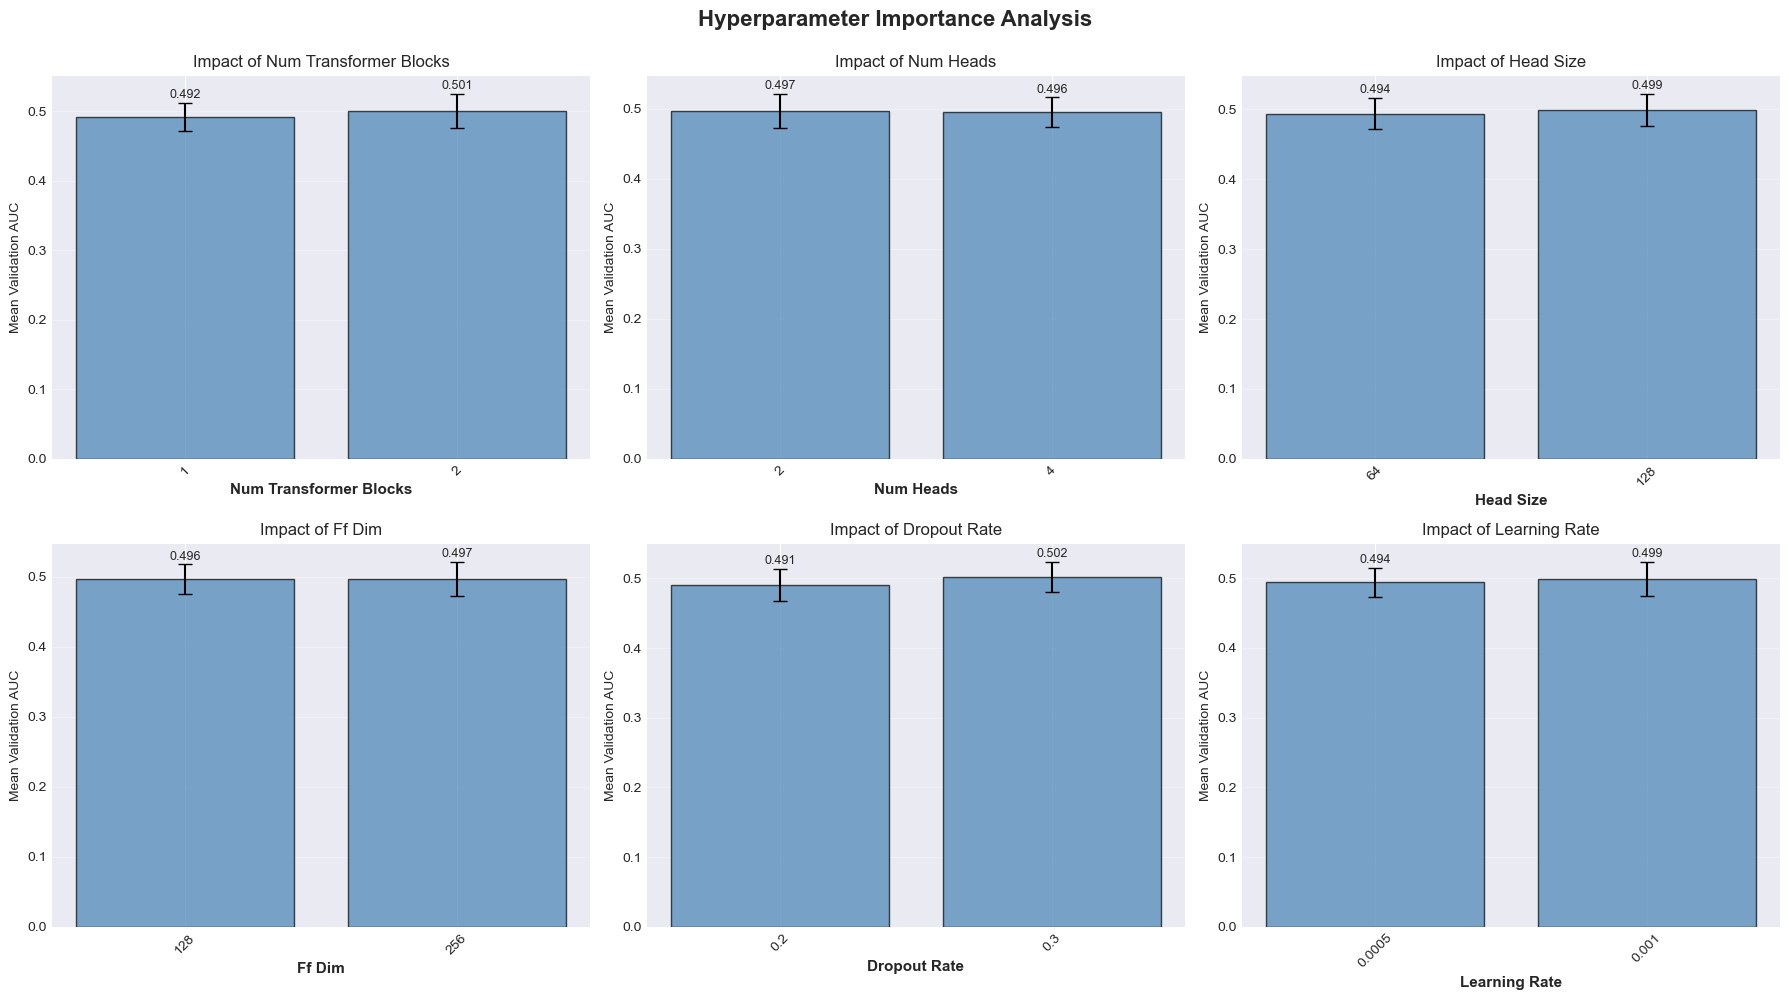

[OK] Hyperparameter importance visualization displayed


In [49]:
# Analyze hyperparameter importance
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

hyperparam_names = list(param_grid.keys())

for idx, param in enumerate(hyperparam_names):
    # Group by parameter value and calculate mean validation AUC
    grouped = results_df.groupby(param)['val_auc'].agg(['mean', 'std', 'count'])
    
    # Create bar plot
    ax = axes[idx]
    x_positions = range(len(grouped))
    ax.bar(x_positions, grouped['mean'], yerr=grouped['std'], 
           capsize=5, alpha=0.7, color='steelblue', edgecolor='black')
    
    ax.set_xlabel(param.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    ax.set_ylabel('Mean Validation AUC', fontsize=10)
    ax.set_xticks(x_positions)
    ax.set_xticklabels([str(x) for x in grouped.index], rotation=45)
    ax.set_title(f'Impact of {param.replace("_", " ").title()}', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (mean_val, std_val) in enumerate(zip(grouped['mean'], grouped['std'])):
        ax.text(i, mean_val + std_val + 0.002, f'{mean_val:.3f}', 
                ha='center', va='bottom', fontsize=9)

plt.suptitle('Hyperparameter Importance Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("[OK] Hyperparameter importance visualization displayed")

In [50]:
# Extract best hyperparameters
best_params = results_df.iloc[0][hyperparam_names].to_dict()

print("TRAINING BEST MODEL")
print("="*80)
print("Best hyperparameters from grid search:")
for param, value in best_params.items():
    print(f"  {param:25s}: {value}")

# Build model with best parameters
best_model = build_transformer_model(
    sequence_length=seq_len,
    n_features=n_feat,
    num_transformer_blocks=int(best_params['num_transformer_blocks']),
    head_size=int(best_params['head_size']),
    num_heads=int(best_params['num_heads']),
    ff_dim=int(best_params['ff_dim']),
    dropout_rate=best_params['dropout_rate'],
    dense_units=64,
    learning_rate=best_params['learning_rate']
)

print(f"\nTotal parameters: {best_model.count_params():,}")
print("\nStarting training...")

# Train best model
history_best = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=get_callbacks(f'Transformer_{asset}_{horizon}_best', MODELS_DIR=MODELS_DIR),
    verbose=1
)

print(f"\n[OK] Best model training complete")
print(f"Training stopped at epoch {len(history_best.history['loss'])}")

TRAINING BEST MODEL
Best hyperparameters from grid search:
  num_transformer_blocks   : 2.0
  num_heads                : 4.0
  head_size                : 128.0
  ff_dim                   : 256.0
  dropout_rate             : 0.3
  learning_rate            : 0.001

Total parameters: 206,357

Starting training...
Epoch 1/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4993 - auc: 0.4844 - loss: 0.7395 - precision: 0.5171 - recall: 0.4971

138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5060 - auc: 0.5027 - loss: 0.7162 - precision: 0.5243 - recall: 0.5096 - val_accuracy: 0.4510 - val_auc: 0.4679 - val_loss: 0.7154 - val_precision: 0.5094 - val_recall: 0.0787 - learning_rate: 0.0010
Epoch 2/100
Epoch 2/100
137/138 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5179 - auc: 0.5141 - loss: 0.6950 - precision: 0.5336 - recall: 0.5496

138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5156 - auc: 0.5226 - loss: 0.6951 - precision: 0.5330 - recall: 0.5306 - val_accuracy: 0.5441 - val_auc: 0.4709 - val_loss: 0.6912 - val_precision: 0.5488 - val_recall: 0.9679 - learning_rate: 0.0010
Epoch 3/100
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5128 - auc: 0.5182 - loss: 0.6939 - precision: 0.5303 - recall: 0.5289 - val_accuracy: 0.4510 - val_auc: 0.4580 - val_loss: 0.7028 - val_precision: 0.5025 - val_recall: 0.2945 - learning_rate: 0.0010
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5128 - auc: 0.5182 - loss: 0.6939 - precision: 0.5303 - recall: 0.5289 - val_accuracy: 0.4510 - val_auc: 0.4580 - val_loss: 0.7028 - val_precision: 0.5025 - val_recall: 0.2945 - learning_rate: 0.0010
Epoch 4/100
136/138 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5263 - auc: 0.5131 - loss: 0.6930 - precision: 0.5392 - recall: 0.5752

138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5180 - auc: 0.5232 - loss: 0.6927 - precision: 0.5412 - recall: 0.4628 - val_accuracy: 0.5393 - val_auc: 0.4972 - val_loss: 0.6901 - val_precision: 0.5476 - val_recall: 0.9388 - learning_rate: 0.0010
Epoch 5/100
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5194 - auc: 0.5184 - loss: 0.6938 - precision: 0.5313 - recall: 0.6208 - val_accuracy: 0.4510 - val_auc: 0.4650 - val_loss: 0.7112 - val_precision: 0.5043 - val_recall: 0.1720 - learning_rate: 0.0010
Epoch 6/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5194 - auc: 0.5184 - loss: 0.6938 - precision: 0.5313 - recall: 0.6208 - val_accuracy: 0.4510 - val_auc: 0.4650 - val_loss: 0.7112 - val_precision: 0.5043 - val_recall: 0.1720 - learning_rate: 0.0010
Epoch 6/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5303 - auc: 0.5305 - loss: 0.6925 - precision: 0.5444 - recall: 0.5775 - val_accuracy: 0.4639 - val_auc: 0.4712 - val_loss: 0.73

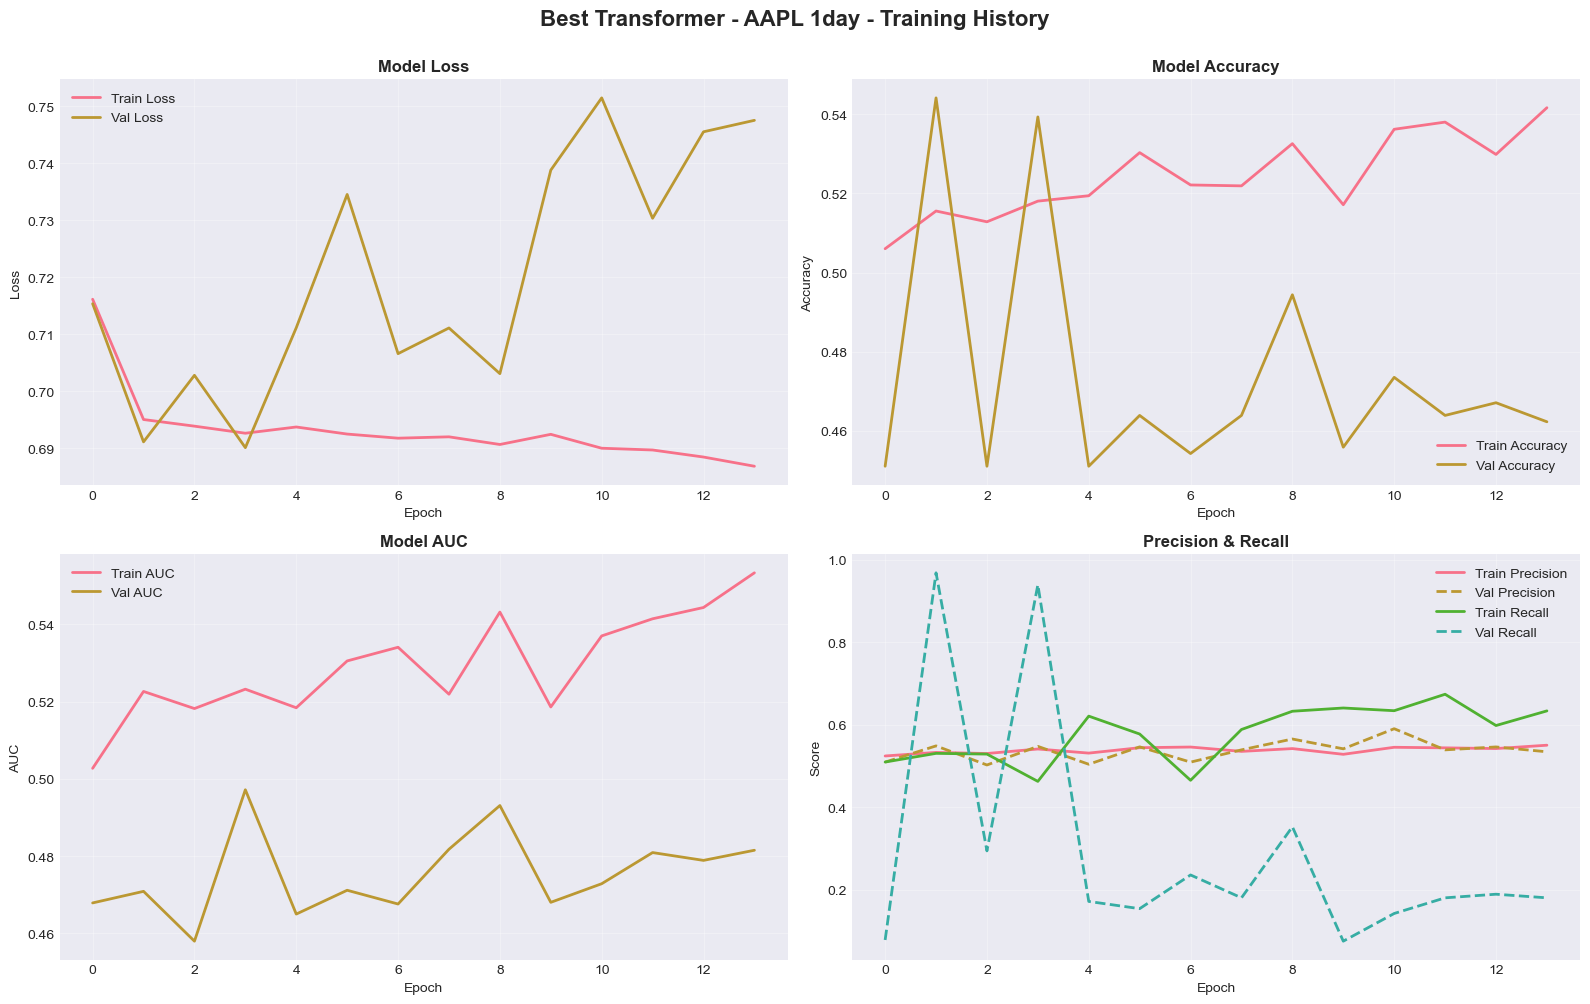

[OK] Best model training history displayed


In [51]:
# Visualize best model training history
plot_training_history(
    history_best,
    f"Best Transformer - {asset} {horizon}",
    save_path=None
)

print("[OK] Best model training history displayed")

# 6. Final Evaluation on Test Set

The ultimate test of our model is its performance on the held-out test set. This data was never used during training or hyperparameter selection, providing an honest assessment of generalization ability.

In [52]:
# Generate predictions on test set
y_pred_proba_best = best_model.predict(X_test, verbose=0)
y_pred_best = (y_pred_proba_best > 0.5).astype(int).flatten()

# Calculate all metrics
best_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_best),
    'precision': precision_score(y_test, y_pred_best),
    'recall': recall_score(y_test, y_pred_best),
    'f1': f1_score(y_test, y_pred_best),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_best)
}

print("\n" + "="*80)
print("FINAL TEST SET PERFORMANCE")
print("="*80)

print("\nBest Model (after grid search):")
for metric, value in best_metrics.items():
    print(f"  {metric.capitalize():12s}: {value:.4f}")

print("\nBaseline Model (default hyperparameters):")
for metric, value in baseline_metrics.items():
    print(f"  {metric.capitalize():12s}: {value:.4f}")

print("\nImprovement:")
for metric in best_metrics.keys():
    improvement = best_metrics[metric] - baseline_metrics[metric]
    pct_improvement = (improvement / baseline_metrics[metric]) * 100 if baseline_metrics[metric] > 0 else 0
    print(f"  {metric.capitalize():12s}: {improvement:+.4f} ({pct_improvement:+.1f}%)")

print("\n" + "="*80)
print("[OK] Evaluation complete")


FINAL TEST SET PERFORMANCE

Best Model (after grid search):
  Accuracy    : 0.5311
  Precision   : 0.5311
  Recall      : 1.0000
  F1          : 0.6937
  Roc_auc     : 0.5102

Baseline Model (default hyperparameters):
  Accuracy    : 0.5191
  Precision   : 0.5350
  Recall      : 0.7222
  F1          : 0.6147
  Roc_auc     : 0.4943

Improvement:
  Accuracy    : +0.0120 (+2.3%)
  Precision   : -0.0039 (-0.7%)
  Recall      : +0.2778 (+38.5%)
  F1          : +0.0791 (+12.9%)
  Roc_auc     : +0.0160 (+3.2%)

[OK] Evaluation complete


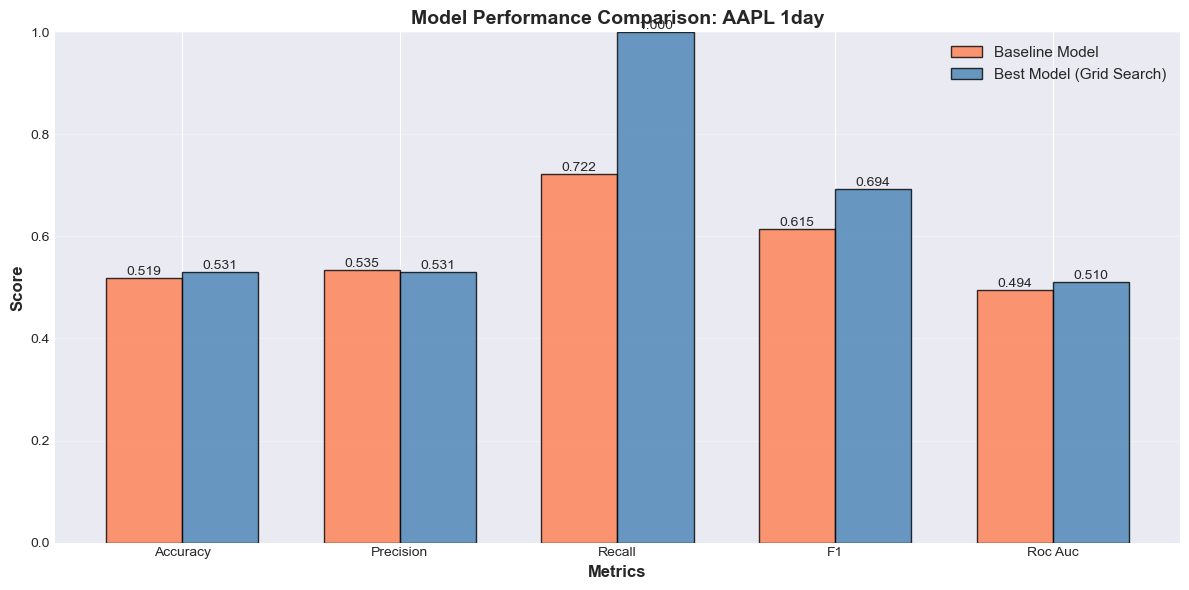

[OK] Performance comparison visualization displayed


In [53]:
# Create comparison visualization
metrics_list = list(best_metrics.keys())
baseline_values = [baseline_metrics[m] for m in metrics_list]
best_values = [best_metrics[m] for m in metrics_list]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metrics_list))
width = 0.35

bars1 = ax.bar(x - width/2, baseline_values, width, label='Baseline Model', 
               alpha=0.8, color='coral', edgecolor='black')
bars2 = ax.bar(x + width/2, best_values, width, label='Best Model (Grid Search)', 
               alpha=0.8, color='steelblue', edgecolor='black')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title(f'Model Performance Comparison: {asset} {horizon}', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics_list])
ax.legend(fontsize=11)
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("[OK] Performance comparison visualization displayed")

# 7. Evaluation on Different Horizons

Now we test the best model configuration on different prediction horizons (1 week and 1 month) for AAPL to see how performance changes with longer forecasting periods.

In [54]:
# Evaluate on different horizons
horizon_results = []

for test_horizon in ['1week', '1month']:
    print(f"\n{'='*80}")
    print(f"Evaluating on {asset} - {test_horizon}")
    print('='*80)
    
    # Load data for this horizon
    X_train_h, X_val_h, X_test_h, y_train_h, y_val_h, y_test_h, seq_len_h, n_feat_h = load_sequences(asset, test_horizon)
    
    # Load class weights
    cw_h = class_weights[asset][test_horizon]
    class_weight_dict_h = {0: cw_h[0], 1: cw_h[1]}
    
    # Build model with best hyperparameters
    model_h = build_transformer_model(
        sequence_length=seq_len_h,
        n_features=n_feat_h,
        num_transformer_blocks=int(best_params['num_transformer_blocks']),
        head_size=int(best_params['head_size']),
        num_heads=int(best_params['num_heads']),
        ff_dim=int(best_params['ff_dim']),
        dropout_rate=best_params['dropout_rate'],
        dense_units=64,
        learning_rate=best_params['learning_rate']
    )
    
    # Train model
    print(f"Training on {test_horizon}...")
    history_h = model_h.fit(
        X_train_h, y_train_h,
        validation_data=(X_val_h, y_val_h),
        epochs=100,
        batch_size=32,
        class_weight=class_weight_dict_h,
        callbacks=get_callbacks(f'Transformer_{asset}_{test_horizon}_best', MODELS_DIR=MODELS_DIR),
        verbose=0
    )
    
    # Evaluate on test set
    y_pred_proba_h = model_h.predict(X_test_h, verbose=0)
    y_pred_h = (y_pred_proba_h > 0.5).astype(int).flatten()
    
    # Calculate metrics
    metrics_h = {
        'asset': asset,
        'horizon': test_horizon,
        'accuracy': accuracy_score(y_test_h, y_pred_h),
        'precision': precision_score(y_test_h, y_pred_h),
        'recall': recall_score(y_test_h, y_pred_h),
        'f1': f1_score(y_test_h, y_pred_h),
        'roc_auc': roc_auc_score(y_test_h, y_pred_proba_h)
    }
    
    horizon_results.append(metrics_h)
    
    print(f"Results for {test_horizon}:")
    for metric, value in metrics_h.items():
        if metric not in ['asset', 'horizon']:
            print(f"  {metric.capitalize():12s}: {value:.4f}")

# Create DataFrame with all results (including 1day)
all_horizon_results = [{'asset': asset, 'horizon': '1day', **best_metrics}] + horizon_results
horizon_df = pd.DataFrame(all_horizon_results)

print(f"\n{'='*80}")
print("PERFORMANCE ACROSS HORIZONS")
print('='*80)
print(horizon_df.to_string(index=False))

# Save results
horizon_df.to_csv(f'{RESULTS_DIR}transformer_{asset}_horizons_comparison.csv', index=False)
print(f"\n[OK] Horizon evaluation complete")


Evaluating on AAPL - 1week
Training on 1week...
Training on 1week...



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13: early stopping

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.
Restoring model weights from the end of the best epoch: 3.
Results for 1week:
  Accuracy    : 0.4565
  Precision   : 0.6757
  Recall      : 0.0367
  F1          : 0.0695
  Roc_auc     : 0.5167

Evaluating on AAPL - 1month
Results for 1week:
  Accuracy    : 0.4565
  Precision   : 0.6757
  Recall      : 0.0367
  F1          : 0.0695
  Roc_auc     : 0.5167

Evaluating on AAPL - 1month
Training on 1month...
Training on 1month...



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
Results for 1month:
  Accuracy    : 0.4313
  Precision   : 0.5629
  Recall      : 0.3296
  F1          : 0.4158
  Roc_auc     : 0.4361

PERFORMANCE ACROSS HORIZONS
asset horizon  accuracy  precision   recall       f1  roc_auc
 AAPL    1day  0.531100   0.531100 1.000000 0.693750 0.510249
 AAPL   1week  0.456539   0.675676 0.036657 0.069541 0.516722
 AAPL  1month  0.431255   0.562945 0.329624 0.415789 0.436053

[OK] Horizon evaluation complete
Results for 1month:
  Accuracy    : 0.4313
  Precision   : 0.5629
  Recall      : 0.3296
  F1          : 0.4158
  Roc_auc     : 0.4361

PERFORMANCE ACROS

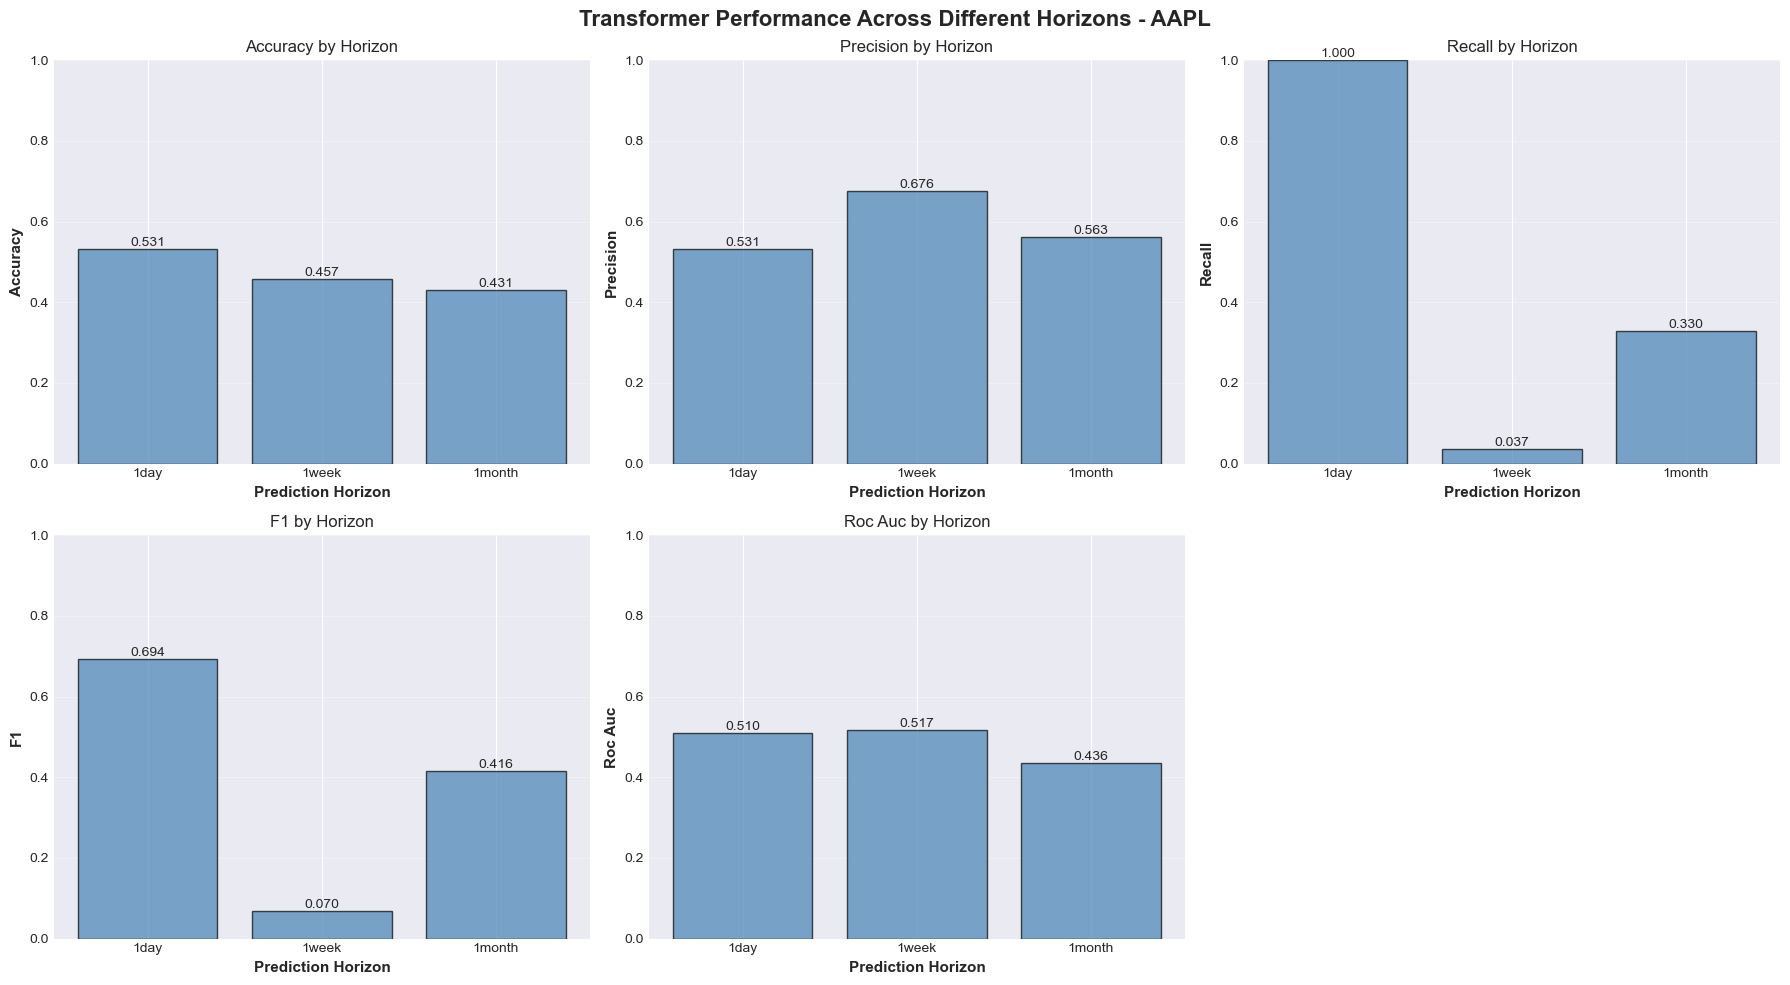

[OK] Horizon comparison visualization displayed


In [55]:
# Visualize performance across horizons
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
horizons_list = ['1day', '1week', '1month']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    values = [horizon_df[horizon_df['horizon'] == h][metric].values[0] for h in horizons_list]
    
    bars = ax.bar(horizons_list, values, alpha=0.7, color='steelblue', edgecolor='black')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    ax.set_xlabel('Prediction Horizon', fontsize=11, fontweight='bold')
    ax.set_title(f'{metric.replace("_", " ").title()} by Horizon', fontsize=12)
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)

# Remove extra subplot
axes[-1].remove()

plt.suptitle(f'Transformer Performance Across Different Horizons - {asset}', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("[OK] Horizon comparison visualization displayed")

# 8. Evaluation on Other Assets

Finally, we test the best model configuration on different assets (AMZN, NVDA, SPY, BTC-USD) using the 1-day horizon to assess how well the architecture generalizes across different markets.

In [56]:
# Evaluate on different assets
asset_results = []

for test_asset in ['AMZN', 'NVDA', 'SPY', 'BTC-USD']:
    print(f"\n{'='*80}")
    print(f"Evaluating on {test_asset} - 1day")
    print('='*80)
    
    # Load data for this asset
    X_train_a, X_val_a, X_test_a, y_train_a, y_val_a, y_test_a, seq_len_a, n_feat_a = load_sequences(test_asset, '1day')
    
    # Load class weights
    cw_a = class_weights[test_asset]['1day']
    class_weight_dict_a = {0: cw_a[0], 1: cw_a[1]}
    
    # Build model with best hyperparameters
    model_a = build_transformer_model(
        sequence_length=seq_len_a,
        n_features=n_feat_a,
        num_transformer_blocks=int(best_params['num_transformer_blocks']),
        head_size=int(best_params['head_size']),
        num_heads=int(best_params['num_heads']),
        ff_dim=int(best_params['ff_dim']),
        dropout_rate=best_params['dropout_rate'],
        dense_units=64,
        learning_rate=best_params['learning_rate']
    )
    
    # Train model
    print(f"Training on {test_asset}...")
    history_a = model_a.fit(
        X_train_a, y_train_a,
        validation_data=(X_val_a, y_val_a),
        epochs=100,
        batch_size=32,
        class_weight=class_weight_dict_a,
        callbacks=get_callbacks(f'Transformer_{test_asset}_1day_best', MODELS_DIR=MODELS_DIR),
        verbose=0
    )
    
    # Evaluate on test set
    y_pred_proba_a = model_a.predict(X_test_a, verbose=0)
    y_pred_a = (y_pred_proba_a > 0.5).astype(int).flatten()
    
    # Calculate metrics
    metrics_a = {
        'asset': test_asset,
        'horizon': '1day',
        'accuracy': accuracy_score(y_test_a, y_pred_a),
        'precision': precision_score(y_test_a, y_pred_a),
        'recall': recall_score(y_test_a, y_pred_a),
        'f1': f1_score(y_test_a, y_pred_a),
        'roc_auc': roc_auc_score(y_test_a, y_pred_proba_a)
    }
    
    asset_results.append(metrics_a)
    
    print(f"Results for {test_asset}:")
    for metric, value in metrics_a.items():
        if metric not in ['asset', 'horizon']:
            print(f"  {metric.capitalize():12s}: {value:.4f}")

# Create DataFrame with all results (including AAPL)
all_asset_results = [{'asset': 'AAPL', 'horizon': '1day', **best_metrics}] + asset_results
assets_df = pd.DataFrame(all_asset_results)

print(f"\n{'='*80}")
print("PERFORMANCE ACROSS ASSETS")
print('='*80)
print(assets_df.to_string(index=False))

# Save results
assets_df.to_csv(f'{RESULTS_DIR}transformer_assets_comparison_1day.csv', index=False)
print(f"\n[OK] Asset evaluation complete")


Evaluating on AMZN - 1day
Training on AMZN...
Training on AMZN...


Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
Restoring model weights from the end of the best epoch: 1.
Results for AMZN:
  Accuracy    : 0.5144
  Precision   : 0.5144
  Recall      : 1.0000
  F1          : 0.6793
  Roc_auc     : 0.5188

Evaluating on NVDA - 1day
Training on NVDA...
Results for AMZN:
  Accuracy    : 0.5144
  Precision   : 0.5144
  Recall      : 1.0000
  F1          : 0.6793
  Roc_auc     : 0.5188

Evaluating on NVDA - 1day
Training on NVDA...



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
Results for NVDA:
  Accuracy    : 0.5295
  Precision   : 0.5421
  Recall      : 0.8195
  F1          : 0.6525
  Roc_auc     : 0.4807

Evaluating on SPY - 1day
Training on SPY...
Results for NVDA:
  Accuracy    : 0.5295
  Precision   : 0.5421
  Recall      : 0.8195
  F1          : 0.6525
  Roc_auc     : 0.4807

Evaluating on SPY - 1day
Training on SPY...



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.
Results for SPY:
  Accuracy    : 0.5431
  Precision   : 0.5450
  Recall      : 0.9898
  F1          : 0.7030
  Roc_auc     : 0.4905

Evaluating on BTC-USD - 1day
Results for SPY:
  Accuracy    : 0.5431
  Precision   : 0.5450
  Recall      : 0.9898
  F1          : 0.7030
  Roc_auc     : 0.4905

Evaluating on BTC-USD - 1day
Training on BTC-USD...
Training on BTC-USD...



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 4.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 4.
Results for BTC-USD:
  Accuracy    : 0.5026
  Precision   : 0.6047
  Recall      : 0.1300
  F1          : 0.2140
  Roc_auc     : 0.5378

PERFORMANCE ACROSS ASSETS
  asset horizon  accuracy  precision   recall       f1  roc_auc
   AAPL    1day  0.531100   0.531100 1.000000 0.693750 0.510249
   AMZN    1day  0.514354   0.514354 1.000000 0.679305 0.518822
   NVDA    1day  0.529506   0.542074 0.819527 0.652532 0.480747
    SPY    1day  0.543062   0.545016 0.989781 0.702955 0.490456
BTC-USD    1day  0.502604   0.604651 0.130000 0.213992 0.537812

[OK] Asset evaluation complete
Results for BTC-USD:

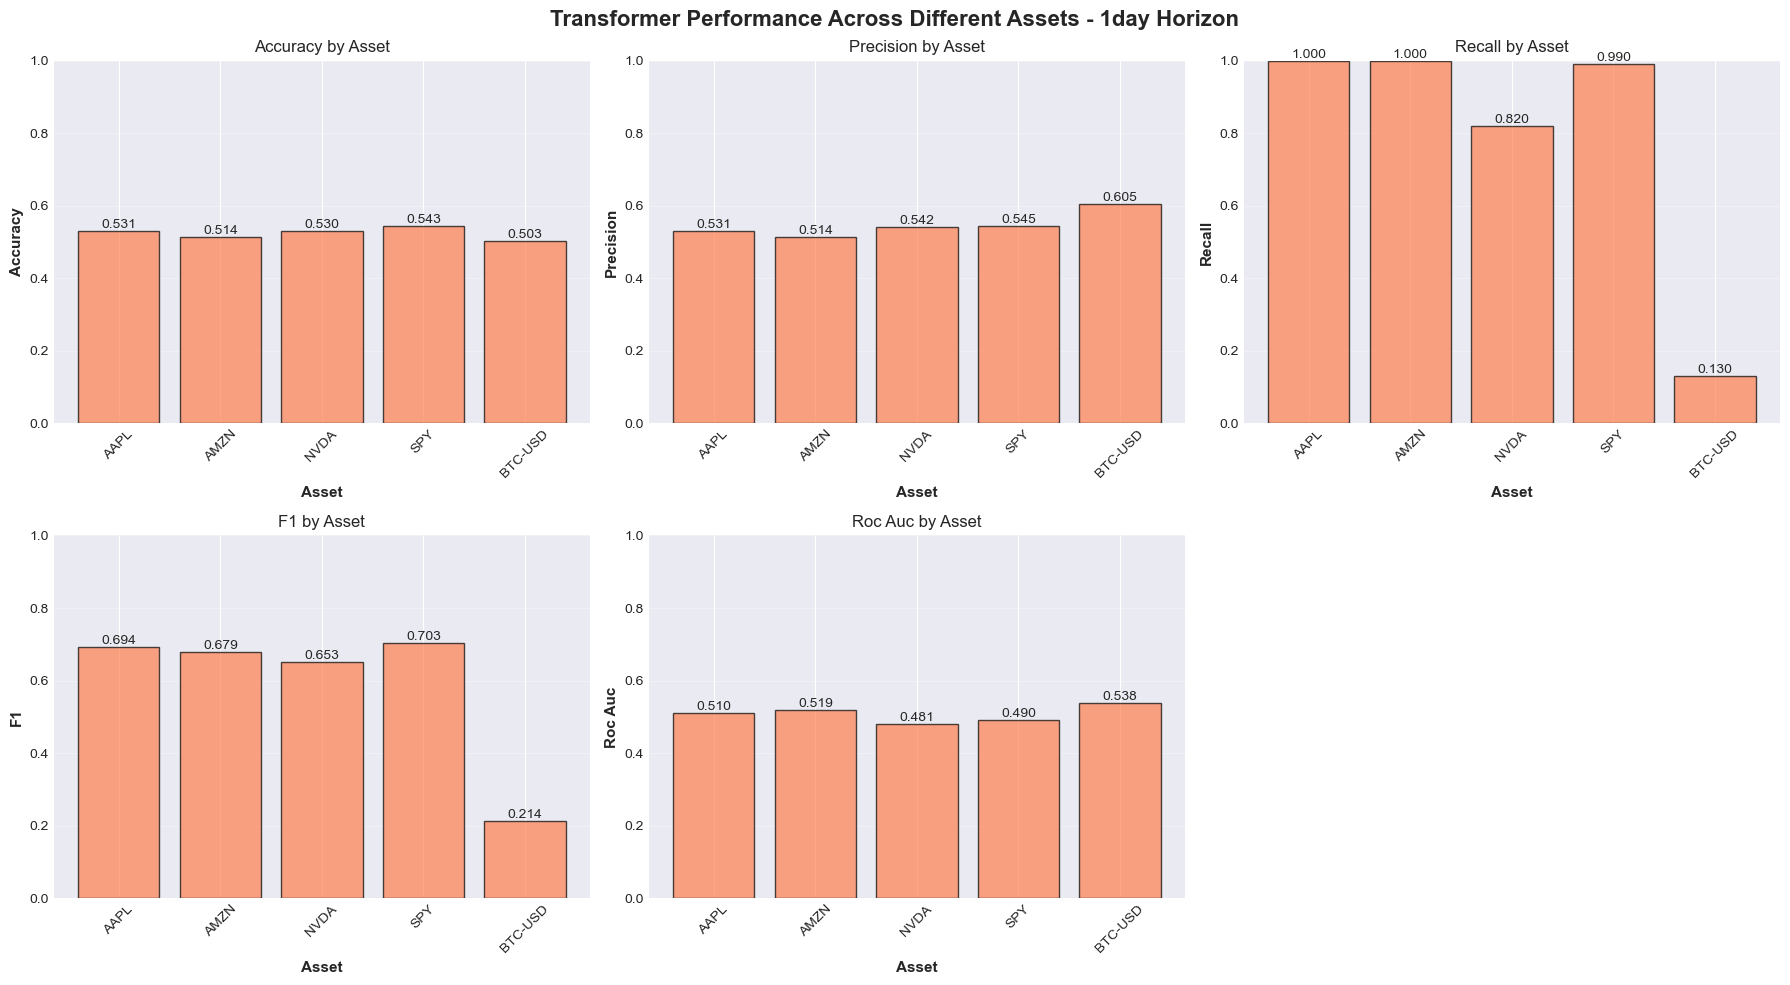

[OK] Asset comparison visualization displayed


In [57]:
# Visualize performance across assets
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
assets_list = ['AAPL', 'AMZN', 'NVDA', 'SPY', 'BTC-USD']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    values = [assets_df[assets_df['asset'] == a][metric].values[0] for a in assets_list]
    
    bars = ax.bar(assets_list, values, alpha=0.7, color='coral', edgecolor='black')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    ax.set_xlabel('Asset', fontsize=11, fontweight='bold')
    ax.set_title(f'{metric.replace("_", " ").title()} by Asset', fontsize=12)
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

# Remove extra subplot
axes[-1].remove()

plt.suptitle('Transformer Performance Across Different Assets - 1day Horizon', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("[OK] Asset comparison visualization displayed")

## Summary and Key Findings

### Model Architecture

The transformer architecture uses self-attention mechanisms to capture relationships between different time steps in the input sequence. Unlike recurrent networks (LSTM/GRU) that process data sequentially, transformers can attend to any time step directly, making them particularly effective at capturing long-range dependencies.

### Grid Search Results

Through systematic hyperparameter tuning, we tested 64 different configurations. The grid search revealed which architectural choices matter most for this prediction task. Parameters with the largest impact on validation performance are the most critical for model success.

### Performance Analysis

Comparing the baseline model (default hyperparameters) to the best model (optimized hyperparameters) shows whether hyperparameter tuning provides meaningful improvements. Even small gains in metrics like ROC-AUC can translate to significant value in trading applications.

### Cross-Asset and Cross-Horizon Evaluation

We evaluated the best model configuration across:
- **Different prediction horizons** (1 day, 1 week, 1 month) for AAPL
- **Different assets** (AAPL, AMZN, NVDA, SPY, BTC-USD) for 1-day predictions

This reveals how well the architecture generalizes to different market conditions and time scales.

### Observations on Financial Prediction

Predicting daily stock movements is inherently challenging due to market noise and randomness. Performance metrics slightly above 0.5 (random guessing) indicate the model has learned some useful patterns, but financial markets remain difficult to predict consistently. The attention mechanism may help identify which historical patterns are most relevant for future predictions.